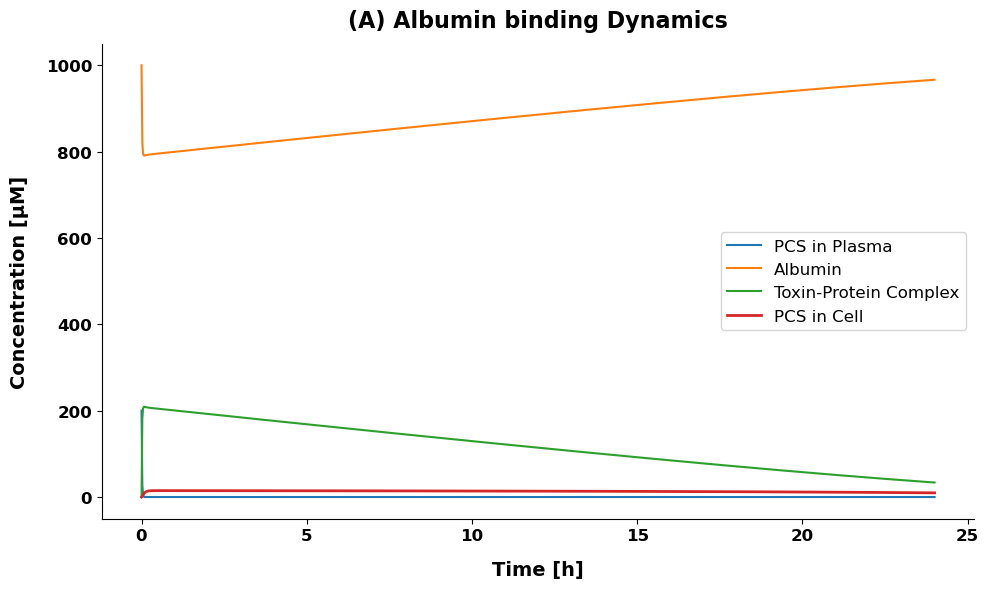

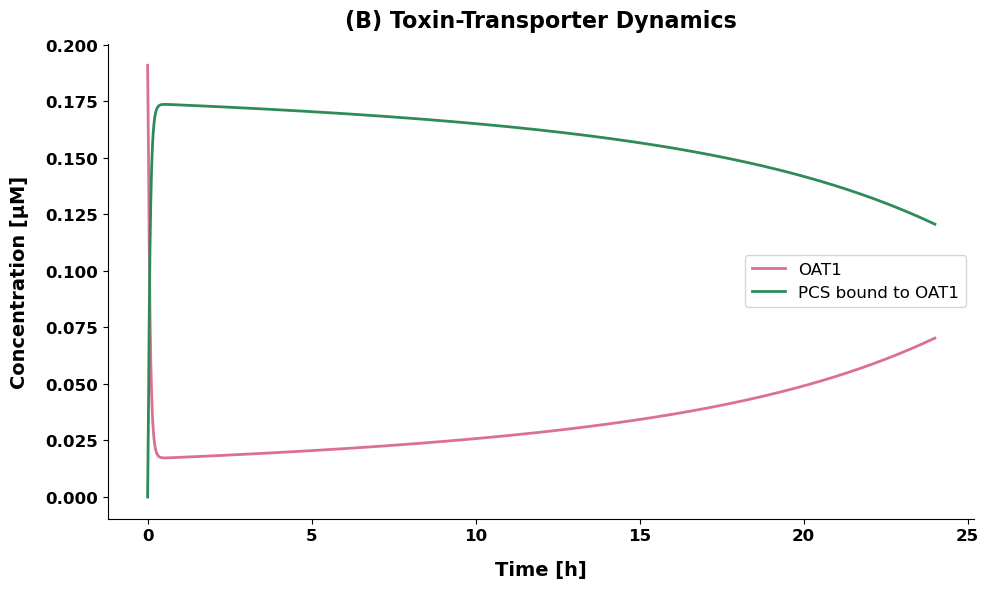

In [508]:
#PHYSIOLOGICAL MODEL
# Steady-state dynamics 
# Testing different uremic conditions (Decreased OAT1 and efflux capacity)
# Predciting urinary excretion of PCS


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Initial conditions
initial_OAT1 = 0.190962
initial_PCS_C = 0
initial_OAT1PCS = 0
initial_HSA = 1000 #microM
initial_Complex = 0
initial_PCS_L = 0

#Uremic
initial_PCS_B = 200
Kf_Uptake = 1.99e-5
Kf_dissociation = 4.05e-04

#Healthy 
#initial_PCS_B = 10
#Kf_Uptake = 1.44e-5
#Kf_dissociation = 5.78e-04

Vmax_Efflux = 0.0003986
Km_Efflux = 69
Vmax_HSA = 0.000864  #Unit 100*microM / m^2 s
Km_HSA = 97.92        

V_Plasma = 0.0001 #L
V_Mem =  0.0032      
V_Cell = 3.2e-07
V_Lumen = 0.0001 #L
V_Bloodstream = 2.4 #L
V_Urine = 1  #L

# Production and removal rates
production_PCS_B = 0.4617 
Km_B = 50.0 

removal_PCS_L =  0.02001  # example removal rate
Km_L = 50.0          # Already defined

# Create params tuple
params = (Kf_Uptake, Kf_dissociation, Vmax_HSA, Km_HSA, Vmax_Efflux, Km_Efflux, V_Plasma, V_Mem, V_Cell, V_Lumen, V_Bloodstream, V_Urine, production_PCS_B, removal_PCS_L, Km_B, Km_L)

y0 = [initial_PCS_B, initial_HSA, initial_Complex, initial_OAT1, initial_OAT1PCS, initial_PCS_C, initial_PCS_L]

def kidney_model(t, y, params):
    PCS_B, HSA, Complex, OAT1, OAT1PCS, PCS_C, PCS_L = y
    Kf_Uptake, Kf_dissociation, Vmax_HSA, Km_HSA, Vmax_Efflux, Km_Efflux, V_Plasma, V_Mem, V_Cell, V_Lumen, V_Bloodstream, V_Urine, production_PCS_B, removal_PCS_L, Km_B, Km_L = params

    # Michaelis-Menten kinetics for complex formation
    def kf_complex(HSA, Vmax_HSA, Km_HSA):
        return Vmax_HSA * HSA / (Km_HSA + HSA)

    # Refined PCS production in plasma with saturable removal
    influx_to_plasma = (production_PCS_B * PCS_B / (Km_B + PCS_B)) / V_Bloodstream # Saturable removal #divide by plasma volumne 
    efflux_plasma = ((kf_complex(HSA, Vmax_HSA, Km_HSA) * PCS_B) * V_Mem) / V_Plasma 
    dPCS_B_dt = (influx_to_plasma - efflux_plasma) 
    
    dHSA_dt = ((-(kf_complex(HSA, Vmax_HSA, Km_HSA) * PCS_B) + (Kf_Uptake * Complex * OAT1)) * V_Mem) / V_Plasma
    dComplex_dt = (((kf_complex(HSA, Vmax_HSA, Km_HSA) * PCS_B) - (Kf_Uptake * Complex * OAT1)) * V_Mem) / V_Plasma
    dOAT1_dt = ((-(Kf_Uptake * Complex * OAT1) + (Kf_dissociation * OAT1PCS)) * V_Mem) / V_Mem
    dOAT1PCS_dt = (((Kf_Uptake * Complex * OAT1) - (Kf_dissociation * OAT1PCS)) * V_Mem) / V_Mem
    dPCS_C_dt = (((Kf_dissociation * OAT1PCS) - ((Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C))) * V_Mem) / V_Cell
    
    # Refined PCS excretion in lumen with saturable removal
    efflux_to_lumen = ((Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) * V_Mem) / V_Lumen
    removal_from_lumen = (removal_PCS_L * PCS_L / (Km_L + PCS_L)) / V_Urine  # Saturable removal
    dPCS_L_dt = (efflux_to_lumen - removal_from_lumen) 

    return [dPCS_B_dt, dHSA_dt, dComplex_dt, dOAT1_dt, dOAT1PCS_dt, dPCS_C_dt, dPCS_L_dt]


t_span = [0, 86400]  # or simulate for 1 hour (3600 seconds)
# One day = 86400
# One hour = 3600
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define evaluation times and initial conditions
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # 1000 points for consistency
y0 = [initial_PCS_B, initial_HSA, initial_Complex, initial_OAT1, initial_OAT1PCS, initial_PCS_C, initial_PCS_L]


# Solve the differential equations using solve_ivp
solution = solve_ivp(
    kidney_model, 
    t_span, 
    y0, 
    args=(params,), 
    t_eval=t_eval, 
    method='BDF',  # Stiff solver
    rtol=1e-6, 
    atol=1e-9
)

# Extract solutions
PCS_B, HSA, Complex, OAT1, OAT1PCS, PCS_C, PCS_L = solution.y

# Plot the results
plt.figure(figsize=(10, 6))

# Uncomment lines below to plot other variables if desired
plt.plot(solution.t / 3600, PCS_B, label='PCS in Plasma')
plt.plot(solution.t / 3600, HSA, label='Albumin')
plt.plot(solution.t / 3600, Complex, label='Toxin-Protein Complex')
plt.plot(solution.t / 3600, PCS_C, label='PCS in Cell', linewidth=2)
plt.xlabel('Time [h]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('(A) Albumin binding Dynamics', fontsize=16, fontweight='bold', pad=12)
plt.tight_layout()
plt.savefig('M_Phys_1.png', dpi=300)
plt.show()

# Plot the results
plt.figure(figsize=(10, 6))

# Uncomment lines below to plot other variables if desired
#plt.plot(solution.t / 60, PCS_B, label='PCS_B')
plt.plot(solution.t / 3600, OAT1, label='OAT1', linewidth=2, color='palevioletred')
plt.plot(solution.t / 3600, OAT1PCS, label='PCS bound to OAT1', linewidth=2, color='seagreen')
#plt.plot(solution.t / 3600, PCS_C, label='PCS in Cell', linewidth=2)
#plt.plot(solution.t / 60, PCS_L, label='PCS in Lumen', linewidth=2, linestyle='--', color='purple')

plt.xlabel('Time [h]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(fontsize=12, loc='right')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('(B) Toxin-Transporter Dynamics', fontsize=16, fontweight='bold', pad=12)
plt.tight_layout()
plt.savefig('M_Phys_2.png', dpi=300)
plt.show()


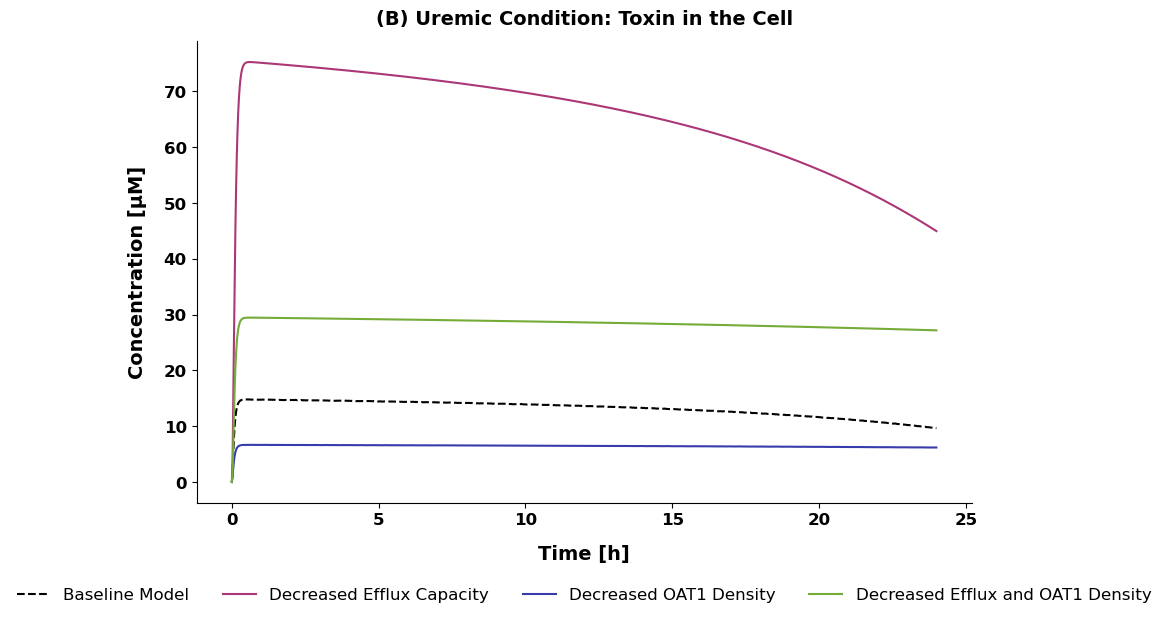

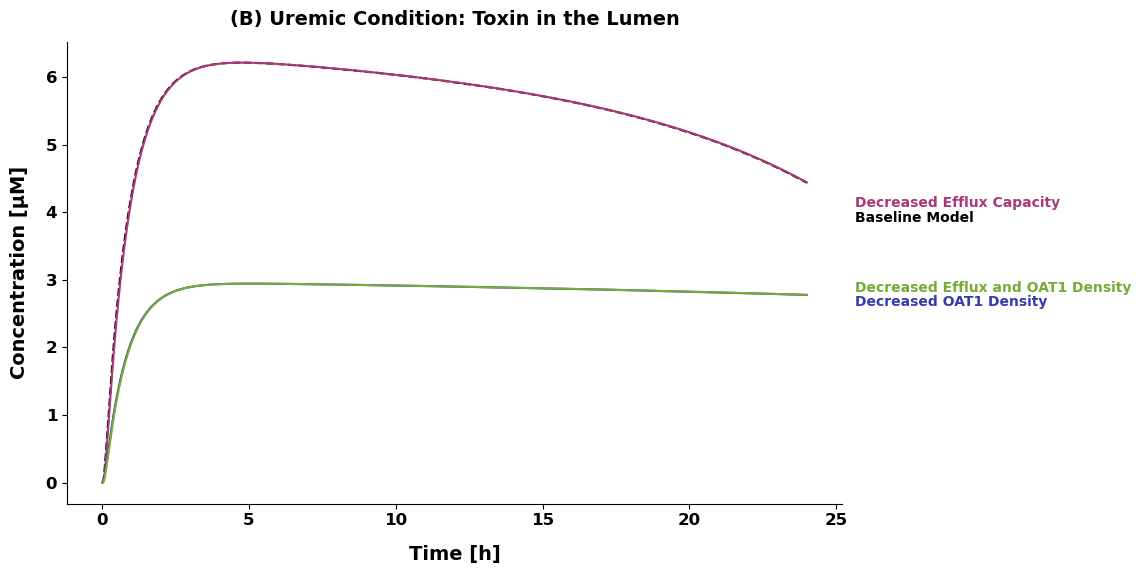

In [509]:

# Different parameter sets for each condition
scenarios = [
    {"name": "Baseline Model", 
     "params": [Kf_Uptake, Kf_dissociation, Vmax_HSA, Km_HSA, 0.0003986, 69, V_Plasma, V_Mem, V_Cell, V_Lumen, V_Bloodstream, V_Urine, production_PCS_B, removal_PCS_L, Km_B, Km_L],
     "initial_conditions": y0},  # Default initial conditions
    
    {"name": "Decreased Efflux Capacity", 
     "params": [Kf_Uptake, Kf_dissociation, Vmax_HSA, Km_HSA, (0.0003986) * 0.5, 138, V_Plasma, V_Mem, V_Cell, V_Lumen, V_Bloodstream, V_Urine, production_PCS_B, removal_PCS_L, Km_B, Km_L],
     "initial_conditions": y0},  # Default initial conditions

    {"name": "Decreased OAT1 Density", 
     "params": [Kf_Uptake, Kf_dissociation, Vmax_HSA, Km_HSA, 0.0003986, 69, V_Plasma, V_Mem, V_Cell, V_Lumen, V_Bloodstream, V_Urine, production_PCS_B, removal_PCS_L, Km_B, Km_L],
     "initial_conditions": [
         initial_PCS_B, 
         initial_HSA, 
         initial_Complex, 
         0.095,  # Decreased initial OAT1 (10% of baseline) 
         initial_OAT1PCS, 
         initial_PCS_C, 
         initial_PCS_L
     ]}, 
    {"name": "Decreased Efflux and OAT1 Density", 
     "params": [Kf_Uptake, Kf_dissociation, Vmax_HSA, Km_HSA, (0.0003986) * 0.5, 138, V_Plasma, V_Mem, V_Cell, V_Lumen, V_Bloodstream, V_Urine, production_PCS_B, removal_PCS_L, Km_B, Km_L],
     "initial_conditions":[
         initial_PCS_B, 
         initial_HSA, 
         initial_Complex, 
         0.095,  # Decreased initial OAT1 (10% of baseline) 
         initial_OAT1PCS, 
         initial_PCS_C, 
         initial_PCS_L
     ]}, 
]

# Store solutions for plotting
solutions = []

for scenario in scenarios:
    # Use modified initial conditions if provided
    initial_conditions = scenario.get("initial_conditions", y0)
    
    solution = solve_ivp(
        kidney_model, 
        t_span, 
        initial_conditions, 
        args=(scenario["params"],), 
        t_eval=t_eval
    )
    solutions.append((scenario["name"], solution))

# Define a list of colors manually
scenario_colors = {
    "Baseline Model": 'black',
    "Decreased Efflux Capacity": '#ab3776',
    "Decreased OAT1 Density": '#373bab',
    "Decreased Efflux and OAT1 Density": '#75ab37',
}

# Plotting PCS_C results
plt.figure(figsize=(10, 6))

# Assuming `solutions` is a list of (name, solution) pairs
for name, solution in solutions:
    
    linestyle = 'dashed' if name == "Baseline Model" else 'solid'

    color = scenario_colors.get(name, 'gray')  # Use color from the dictionary, default to gray if not found
    PCS_C = solution.y[5]  # Assuming PCS_L is the 7th element in the solution.y array
    
    plt.plot(solution.t / 3600, PCS_C, label=f'{name}', color=color, linestyle=linestyle)

plt.xlabel('Time [h]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12, frameon=False)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax = plt.gca()  
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
plt.title('(B) Uremic Condition: Toxin in the Cell', fontsize=14, fontweight='bold', pad=12)
plt.savefig('Phys_2.png', dpi=300)
plt.show()


# Plotting PCS_L results
plt.figure(figsize=(10, 6))

for name, solution in solutions:
    linestyle = 'dashed' if name == "Baseline Model" else 'solid'
    
    color = scenario_colors.get(name, 'gray')  # Use color from the dictionary, default to gray if not found
    PCS_L = solution.y[6]  # Assuming PCS_L is the 7th element in the solution.y array
    
    plt.plot(solution.t / 3600, PCS_L, label=f'{name}', color=color, linestyle=linestyle)
    
    # Dynamically adjust label position
    # Use the average of the last 10 points to determine position
    x_position = solution.t[-1] / 3600
    y_position = PCS_L[-1]
    offset = solutions.index((name, solution)) * 10 - len(solutions) * 7  # Offset to prevent overlap

    plt.annotate(name,
                 xy=(x_position, y_position),  # Place near the end of the line
                 xytext=(35, offset),  # Slightly increase x-offset to move to the right
                 textcoords='offset points',
                 fontsize=10, fontweight='bold', color=color)

plt.xlabel('Time [h]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax = plt.gca()  
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
plt.title('(B) Uremic Condition: Toxin in the Lumen', fontsize=14, fontweight='bold', pad=12)
plt.savefig('Phys_3.png', dpi=300)
plt.show()


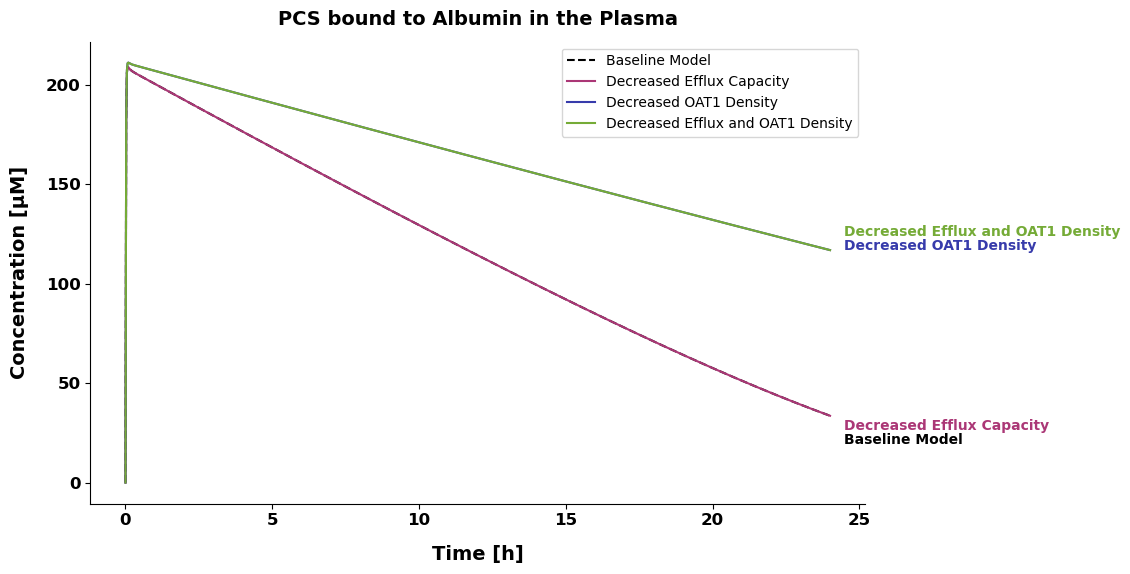

In [510]:
# Plotting PCS_B results
plt.figure(figsize=(10, 6))

for name, solution in solutions:
    linestyle = 'dashed' if name == "Baseline Model" else 'solid'
    color = scenario_colors.get(name, 'gray')  # Use color from the dictionary, default to gray if not found
    Complex = solution.y[2]  # Assuming PCS_L is the 3rd element in the solution.y array

    # Plot the line
    plt.plot(solution.t / 3600, Complex, label=f'{name}', color=color, linestyle=linestyle)

    # Dynamically adjust label position
    # Use the average of the last 10 points to determine position
    x_position = solution.t[-1] / 3600
    y_position = Complex[-1]
    offset = solutions.index((name, solution)) * 10 - len(solutions) * 5  # Offset to prevent overlap

    plt.annotate(name,
                 xy=(x_position, y_position),  # Place near the end of the line
                 xytext=(10, offset),  # Dynamically offset to avoid overlaps
                 textcoords='offset points',
                 fontsize=10, fontweight='bold', color=color)

plt.xlabel('Time [h]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend()  # Optional, can be removed if inline labels are sufficient
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('PCS bound to Albumin in the Plasma', fontsize=14, fontweight='bold', pad=12)
plt.savefig('Phys_4.png', dpi=300, bbox_inches='tight')
plt.show()


In [511]:
# Calculate PCS_B levels in plasma after 24 hours for each condition
results_after_24_hours = {}

for name, solution in solutions:
    # Find the time index closest to 24 hours (86400 seconds)
    time_index = (np.abs(solution.t - 86400)).argmin()
    
    # Get the PCS_B value at this time index
    pcs_b_24h = solution.y[2][time_index]  # Assuming PCS_B is the 3rd entry in solution.y
    
    # Store the result
    results_after_24_hours[name] = pcs_b_24h

# Display the results
for condition, pcs_b in results_after_24_hours.items():
    print(f"{condition}: PCS bound to albumin after 24 hours = {pcs_b:.2f} µM")


Baseline Model: PCS bound to albumin after 24 hours = 33.61 µM
Decreased Efflux Capacity: PCS bound to albumin after 24 hours = 33.61 µM
Decreased OAT1 Density: PCS bound to albumin after 24 hours = 116.91 µM
Decreased Efflux and OAT1 Density: PCS bound to albumin after 24 hours = 116.91 µM


In [512]:
# Iterate through scenarios and find zero-crossing times
for name, solution in solutions:
    PCS_B = solution.y[0]  # Assuming PCS_B is the first element in solution.y array
    times = solution.t / 3600  # Convert time to hours

    # Find the first time PCS_B crosses or reaches zero
    zero_crossing_indices = np.where(PCS_B <= 0)[0]
    if len(zero_crossing_indices) > 0:
        t_zero = times[zero_crossing_indices[0]]  # First point where PCS_B <= 0
        print(f'{name}: PCS_B reaches zero at {t_zero:.2f} hours')
    else:
        print(f'{name}: PCS_B does not reach zero')


Baseline Model: PCS_B reaches zero at 10.62 hours
Decreased Efflux Capacity: PCS_B reaches zero at 0.31 hours
Decreased OAT1 Density: PCS_B reaches zero at 9.99 hours
Decreased Efflux and OAT1 Density: PCS_B reaches zero at 0.31 hours


PCS_L at 24 hours: 4.4361 µM


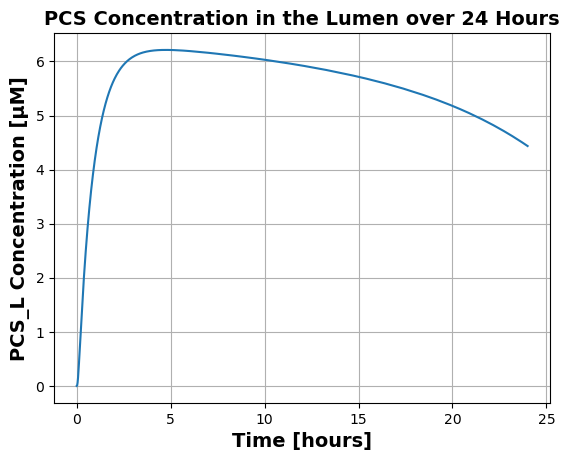

In [513]:
# Time span for 24 hours (in seconds)
time_span = (0, 24 * 60 * 60)  # 24 hours in seconds
time_points = np.linspace(time_span[0], time_span[1], 1000)  # Time points for integration

# Solve the system of ODEs over 24 hours
solution = solve_ivp(kidney_model, time_span, y0, args=(params,), t_eval=time_points)

# Extract PCS_L values from the solution
PCS_L_values = solution.y[6]

# Calculate the value of PCS_L at 24 hours (last point)
PCS_L_at_24h = PCS_L_values[-1]

# Print the result
print(f"PCS_L at 24 hours: {PCS_L_at_24h:.4f} µM")

# Plotting PCS_L over time
plt.plot(solution.t / 3600, PCS_L_values)  # Convert time to hours for plotting
plt.xlabel('Time [hours]', fontsize=14, fontweight='bold')
plt.ylabel('PCS_L Concentration [µM]', fontsize=14, fontweight='bold')
plt.title('PCS Concentration in the Lumen over 24 Hours', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()
